# Supervised Learning - Decision Tree and Random Forest Tree

### Build a decision tree & random forest model with Sales data of a cloth manufacturing company.  

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmet

from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import the dataset
comp_data = pd.read_csv(r"D:\360digi\DS\Sharath\Decision_Tree_2_Master_Class\handson\Datasets_DT\Company_Data.csv")
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [4]:
comp_data.describe() 

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [5]:
# Checking Null Values
comp_data.isnull().sum() # no missing data

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

(array([ 6., 16., 47., 83., 89., 79., 40., 29.,  8.,  3.]),
 array([ 0.   ,  1.627,  3.254,  4.881,  6.508,  8.135,  9.762, 11.389,
        13.016, 14.643, 16.27 ]),
 <BarContainer object of 10 artists>)

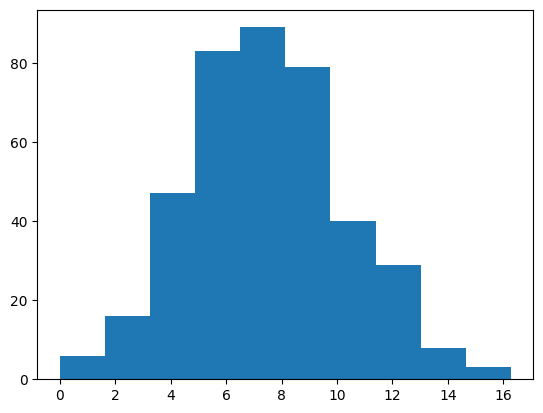

In [6]:
plt.hist(comp_data.Sales)

In [7]:
comp_data.Sales.mean()

7.496325

In [8]:
# grouping the Sales column continuous data into two bins
comp_data['Y'] = pd.cut(x = comp_data.Sales, bins= [0, 7.496325, 17], labels = ['Below_Average', 'Above_Average'], right = False)
comp_data['Y']

0      Above_Average
1      Above_Average
2      Above_Average
3      Below_Average
4      Below_Average
           ...      
395    Above_Average
396    Below_Average
397    Below_Average
398    Below_Average
399    Above_Average
Name: Y, Length: 400, dtype: category
Categories (2, object): ['Below_Average' < 'Above_Average']

In [9]:
# Tried classifying the Sales into 5 bins and the 'Above_Average', 'Excellent' bins have very less data for the model to understand
# comp_data['Y'] = pd.cut(x = comp_data.Sales, bins= [0, 4, 6, 10, 14, 17], labels = ['Poor','Below_Average','Average', 'Above_Average', 'Excellent'], right = False)
# comp_data['Y']

In [10]:
comp_data['Y'].unique()

['Above_Average', 'Below_Average']
Categories (2, object): ['Below_Average' < 'Above_Average']

In [11]:
comp_data['Y'].value_counts()

Below_Average    201
Above_Average    199
Name: Y, dtype: int64

In [12]:
comp_data.head(20)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Y
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Above_Average
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Above_Average
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Above_Average
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,Below_Average
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,Below_Average
5,10.81,124,113,13,501,72,Bad,78,16,No,Yes,Above_Average
6,6.63,115,105,0,45,108,Medium,71,15,Yes,No,Below_Average
7,11.85,136,81,15,425,120,Good,67,10,Yes,Yes,Above_Average
8,6.54,132,110,0,108,124,Medium,76,10,No,No,Below_Average
9,4.69,132,113,0,131,124,Medium,76,17,No,Yes,Below_Average


In [13]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    object  
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    object  
 10  US           400 non-null    object  
 11  Y            400 non-null    category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 35.0+ KB


### Data Preprocessing

In [14]:
df = comp_data.loc[:,'CompPrice':'US':]
df

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,138,73,11,276,120,Bad,42,17,Yes,Yes
1,111,48,16,260,83,Good,65,10,Yes,Yes
2,113,35,10,269,80,Medium,59,12,Yes,Yes
3,117,100,4,466,97,Medium,55,14,Yes,Yes
4,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,Good,33,14,Yes,Yes
396,139,23,3,37,120,Medium,55,11,No,Yes
397,162,26,12,368,159,Medium,40,18,Yes,Yes
398,100,79,7,284,95,Bad,50,12,Yes,Yes


In [15]:
# Target variable categories
target_df = comp_data.loc[:,['Sales', 'Y']]
target_df

,Sales,Y
0,9.50,Above_Average
1,11.22,Above_Average
2,10.06,Above_Average
3,7.40,Below_Average
4,4.15,Below_Average
...,...,...
395,12.57,Above_Average
396,6.14,Below_Average
397,7.41,Below_Average
398,5.94,Below_Average


In [16]:
# how to retrieve columns using index
# comp_data.iloc[:,0:11]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CompPrice    400 non-null    int64 
 1   Income       400 non-null    int64 
 2   Advertising  400 non-null    int64 
 3   Population   400 non-null    int64 
 4   Price        400 non-null    int64 
 5   ShelveLoc    400 non-null    object
 6   Age          400 non-null    int64 
 7   Education    400 non-null    int64 
 8   Urban        400 non-null    object
 9   US           400 non-null    object
dtypes: int64(7), object(3)
memory usage: 31.4+ KB


#### Separating Numeric and Non-Numeric columns

In [18]:
numeric_data = df.select_dtypes(exclude = ['object']).columns
numeric_data

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education'],
      dtype='object')

In [19]:
categorical_data = df.select_dtypes(include = ['object']).columns
categorical_data

Index(['ShelveLoc', 'Urban', 'US'], dtype='object')

In [20]:
df['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [21]:
df['Urban'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
df['US'].unique()

array(['Yes', 'No'], dtype=object)

#### Outlier analysis

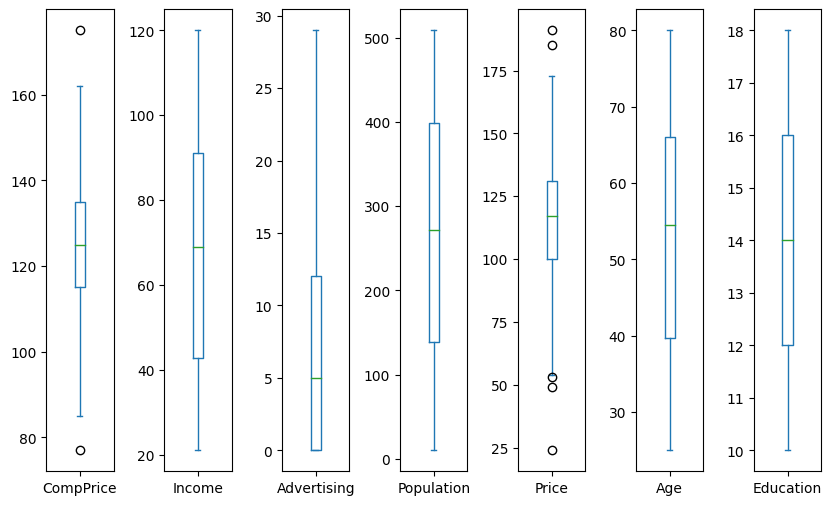

In [23]:
#Box plot visualization to view the outliers.
df[numeric_data].plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6))

plt.subplots_adjust(wspace = 0.75)
plt.show()

#### Winsorization

In [24]:
winsor = Winsorizer(capping_method = 'iqr', # choose  IQR rule boundaries or gaussian for mean and std
                          tail = 'both', # cap left, right or both tails 
                          fold = 1.5,
                          variables = ['CompPrice', 'Price'])

In [25]:
df.columns

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [26]:
clean = winsor.fit(df[['CompPrice', 'Price']])

In [27]:
df[['CompPrice', 'Price']] = clean.transform(df[['CompPrice', 'Price']])
df

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,138.0,73,11,276,120.0,Bad,42,17,Yes,Yes
1,111.0,48,16,260,83.0,Good,65,10,Yes,Yes
2,113.0,35,10,269,80.0,Medium,59,12,Yes,Yes
3,117.0,100,4,466,97.0,Medium,55,14,Yes,Yes
4,141.0,64,3,340,128.0,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...
395,138.0,108,17,203,128.0,Good,33,14,Yes,Yes
396,139.0,23,3,37,120.0,Medium,55,11,No,Yes
397,162.0,26,12,368,159.0,Medium,40,18,Yes,Yes
398,100.0,79,7,284,95.0,Bad,50,12,Yes,Yes


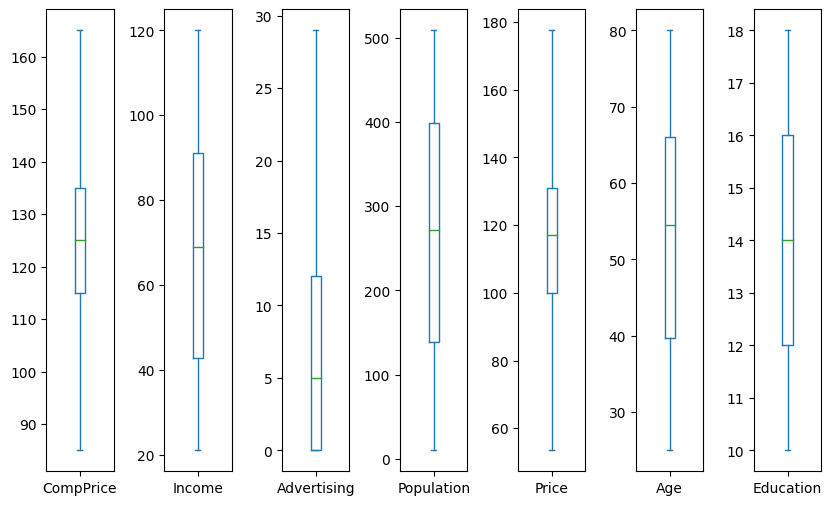

In [28]:
#Box plot visualization to view after the removal of outliers.
df[numeric_data].plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6))

plt.subplots_adjust(wspace = 0.75)
plt.show()

In [29]:
# Checking for Null values
df.isnull().sum() #no misssing values

CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

#### Imputation to handle missing values (not required as we do not have missing values)

In [30]:
num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean'))])

In [31]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipeline, numeric_data)])

In [32]:
imputation = preprocessor.fit(df)

In [33]:
df_num = pd.DataFrame(imputation.transform(df), columns = numeric_data)
df_num

,CompPrice,Income,Advertising,Population,Price,Age,Education
0,138.0,73.0,11.0,276.0,120.0,42.0,17.0
1,111.0,48.0,16.0,260.0,83.0,65.0,10.0
2,113.0,35.0,10.0,269.0,80.0,59.0,12.0
3,117.0,100.0,4.0,466.0,97.0,55.0,14.0
4,141.0,64.0,3.0,340.0,128.0,38.0,13.0
...,...,...,...,...,...,...,...
395,138.0,108.0,17.0,203.0,128.0,33.0,14.0
396,139.0,23.0,3.0,37.0,120.0,55.0,11.0
397,162.0,26.0,12.0,368.0,159.0,40.0,18.0
398,100.0,79.0,7.0,284.0,95.0,50.0,12.0


#### MinMaxScaler to convert the magnitude of the columns to a range of 0 to 1

In [34]:
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

In [35]:
preprocess_pipeline1 = ColumnTransformer([('scale', scale_pipeline, numeric_data)])

In [36]:
scale = preprocess_pipeline1.fit(df_num)

In [37]:
scaled_data = pd.DataFrame(scale.transform(df_num))
scaled_data

,0,1,2,3,4,5,6
0,0.6625,0.525253,0.379310,0.533066,0.536290,0.309091,0.875
1,0.3250,0.272727,0.551724,0.501002,0.237903,0.727273,0.000
2,0.3500,0.141414,0.344828,0.519038,0.213710,0.618182,0.250
3,0.4000,0.797980,0.137931,0.913828,0.350806,0.545455,0.500
4,0.7000,0.434343,0.103448,0.661323,0.600806,0.236364,0.375
...,...,...,...,...,...,...,...
395,0.6625,0.878788,0.586207,0.386774,0.600806,0.145455,0.500
396,0.6750,0.020202,0.103448,0.054108,0.536290,0.545455,0.125
397,0.9625,0.050505,0.413793,0.717435,0.850806,0.272727,1.000
398,0.1875,0.585859,0.241379,0.549098,0.334677,0.454545,0.250


#### Encoding - One Hot Encoder to convert Categorical data to Numeric values

In [38]:
cate_pipeline = Pipeline([('onehot', OneHotEncoder())])

In [39]:
preprocess_pipeline2 = ColumnTransformer(transformers = [('cate', cate_pipeline, categorical_data )])

preprocess_pipeline2

ColumnTransformer(transformers=[('cate',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 Index(['ShelveLoc', 'Urban', 'US'], dtype='object'))])

In [40]:
processed = preprocess_pipeline2.fit(df)

In [41]:
df_cate = pd.DataFrame(processed.transform(df))

In [42]:
df_cate

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
395,0.0,1.0,0.0,0.0,1.0,0.0,1.0
396,0.0,0.0,1.0,1.0,0.0,0.0,1.0
397,0.0,0.0,1.0,0.0,1.0,0.0,1.0
398,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [43]:
# concatenate the data
clean_data = pd.concat([scaled_data, df_cate], axis = 1, ignore_index = True)

In [44]:
clean_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.6625,0.525253,0.379310,0.533066,0.536290,0.309091,0.875,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.3250,0.272727,0.551724,0.501002,0.237903,0.727273,0.000,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.3500,0.141414,0.344828,0.519038,0.213710,0.618182,0.250,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.4000,0.797980,0.137931,0.913828,0.350806,0.545455,0.500,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.7000,0.434343,0.103448,0.661323,0.600806,0.236364,0.375,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.6625,0.878788,0.586207,0.386774,0.600806,0.145455,0.500,0.0,1.0,0.0,0.0,1.0,0.0,1.0
396,0.6750,0.020202,0.103448,0.054108,0.536290,0.545455,0.125,0.0,0.0,1.0,1.0,0.0,0.0,1.0
397,0.9625,0.050505,0.413793,0.717435,0.850806,0.272727,1.000,0.0,0.0,1.0,0.0,1.0,0.0,1.0
398,0.1875,0.585859,0.241379,0.549098,0.334677,0.454545,0.250,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [45]:
# Data split into Input and Output
X = clean_data.loc[:,:]
Y = comp_data['Y'] #target

In [46]:
# Split data into train and test with Stratified sample technique

X_train, X_test, Y_train, Y_test = train_test_split(clean_data, Y, test_size = 0.2, stratify = Y, random_state = 0) 

In [47]:
# Proportion of Target variable categories are consistent across train and test

print(Y_train.value_counts()/ 320)
print("\n")
print(Y_test.value_counts()/ 80)

Below_Average    0.503125
Above_Average    0.496875
Name: Y, dtype: float64


Below_Average    0.5
Above_Average    0.5
Name: Y, dtype: float64


## Decision Tree Model

In [48]:
model = DT(criterion = 'entropy')
model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy')

In [49]:
# Prediction on Test Data
preds = model.predict(X_test)
preds

array(['Below_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Above_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Above_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Below_Average', '

In [50]:
# Accuracy
print(accuracy_score(Y_test, preds))

0.775


In [51]:
pd.crosstab(Y_test, preds, rownames = ['Actual'], colnames= ['Predictions']) 

Predictions,Above_Average,Below_Average
Actual,,
Below_Average,9,31
Above_Average,31,9


[Text(0.5, 1.0, 'Sales Classification Confusion Matrix(Train)'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

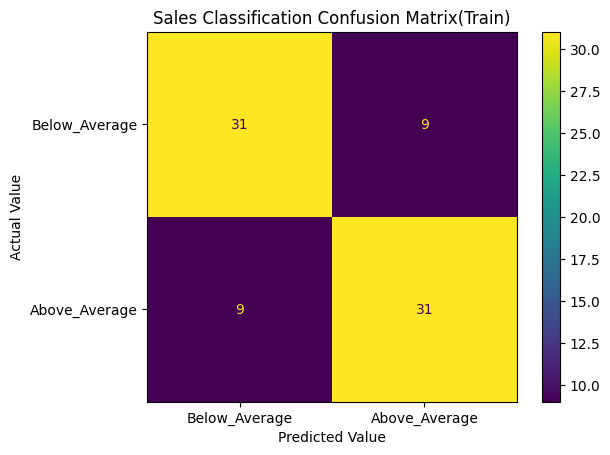

In [52]:
# Confusion Matrix - Heat Map
cm = skmet.confusion_matrix(Y_test, preds)
cmplot = skmet.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Below_Average', 'Above_Average'])
cmplot.plot()
cmplot.ax_.set(title = 'Sales Classification Confusion Matrix(Train)', 
               xlabel = 'Predicted Value', ylabel = 'Actual Value')

## Hyperparameter Optimization

In [53]:
# create a dictionary of all hyperparameters to be experimented
param_grid = { 'criterion': ['gini', 'entropy'], 'max_depth': np.arange(3, 15)}

# Decision tree model
dtree_model = DT()

# GridsearchCV with cross-validation to perform experiments with parameters set
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv = 5, scoring = 'accuracy', return_train_score = False, verbose = 1 )

In [54]:
# Train
dtree_gscv.fit(clean_data, Y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='accuracy', verbose=1)

In [55]:
# The best set of parameter values
dtree_gscv.best_params_

{'criterion': 'entropy', 'max_depth': 11}

In [56]:
# Model with best parameter values
DT_best = dtree_gscv.best_estimator_

In [57]:
DT_best

DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [58]:
# Prediction on Test Data

preds1 = DT_best.predict(X_test)
preds1

array(['Below_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Above_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Above_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Above_Average', 'Below_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Above_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Above_Average', '

In [59]:
pd.crosstab(Y_test, preds1, rownames = ['Actual'], colnames= ['Predictions']) 

Predictions,Above_Average,Below_Average
Actual,,
Below_Average,0,40
Above_Average,40,0


[Text(0.5, 1.0, 'Sales Classification Confusion Matrix(Train)'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

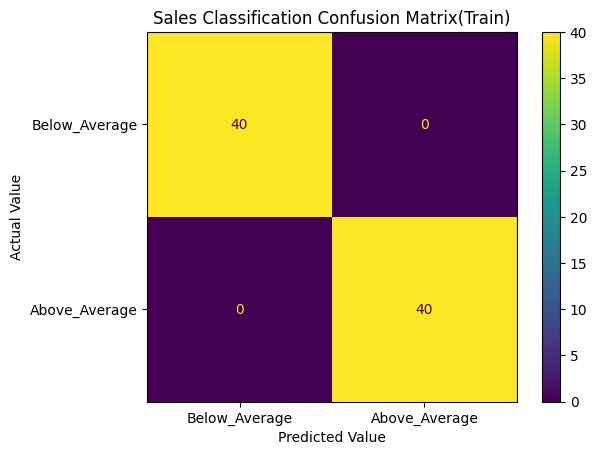

In [60]:
# Confusion Matrix - Heat Map
cm = skmet.confusion_matrix(Y_test, preds1)
cmplot = skmet.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Below_Average', 'Above_Average'])
cmplot.plot()
cmplot.ax_.set(title = 'Sales Classification Confusion Matrix(Train)', 
               xlabel = 'Predicted Value', ylabel = 'Actual Value')

In [61]:
# Accuracy

print(accuracy_score(Y_test, preds1))

1.0


In [62]:
import os
import graphviz
from sklearn import tree
from sklearn.tree import export_graphviz

In [63]:
predictors = list(clean_data.columns)
type(predictors)

list

In [64]:
dot_data = tree.export_graphviz(DT_best, filled = True, 
                                rounded = True,
                                feature_names = predictors,
                                class_names = ['Average', 'Above_Average', 'Below_Average', 'Poor', 'Excellent'],
                                out_file = None)

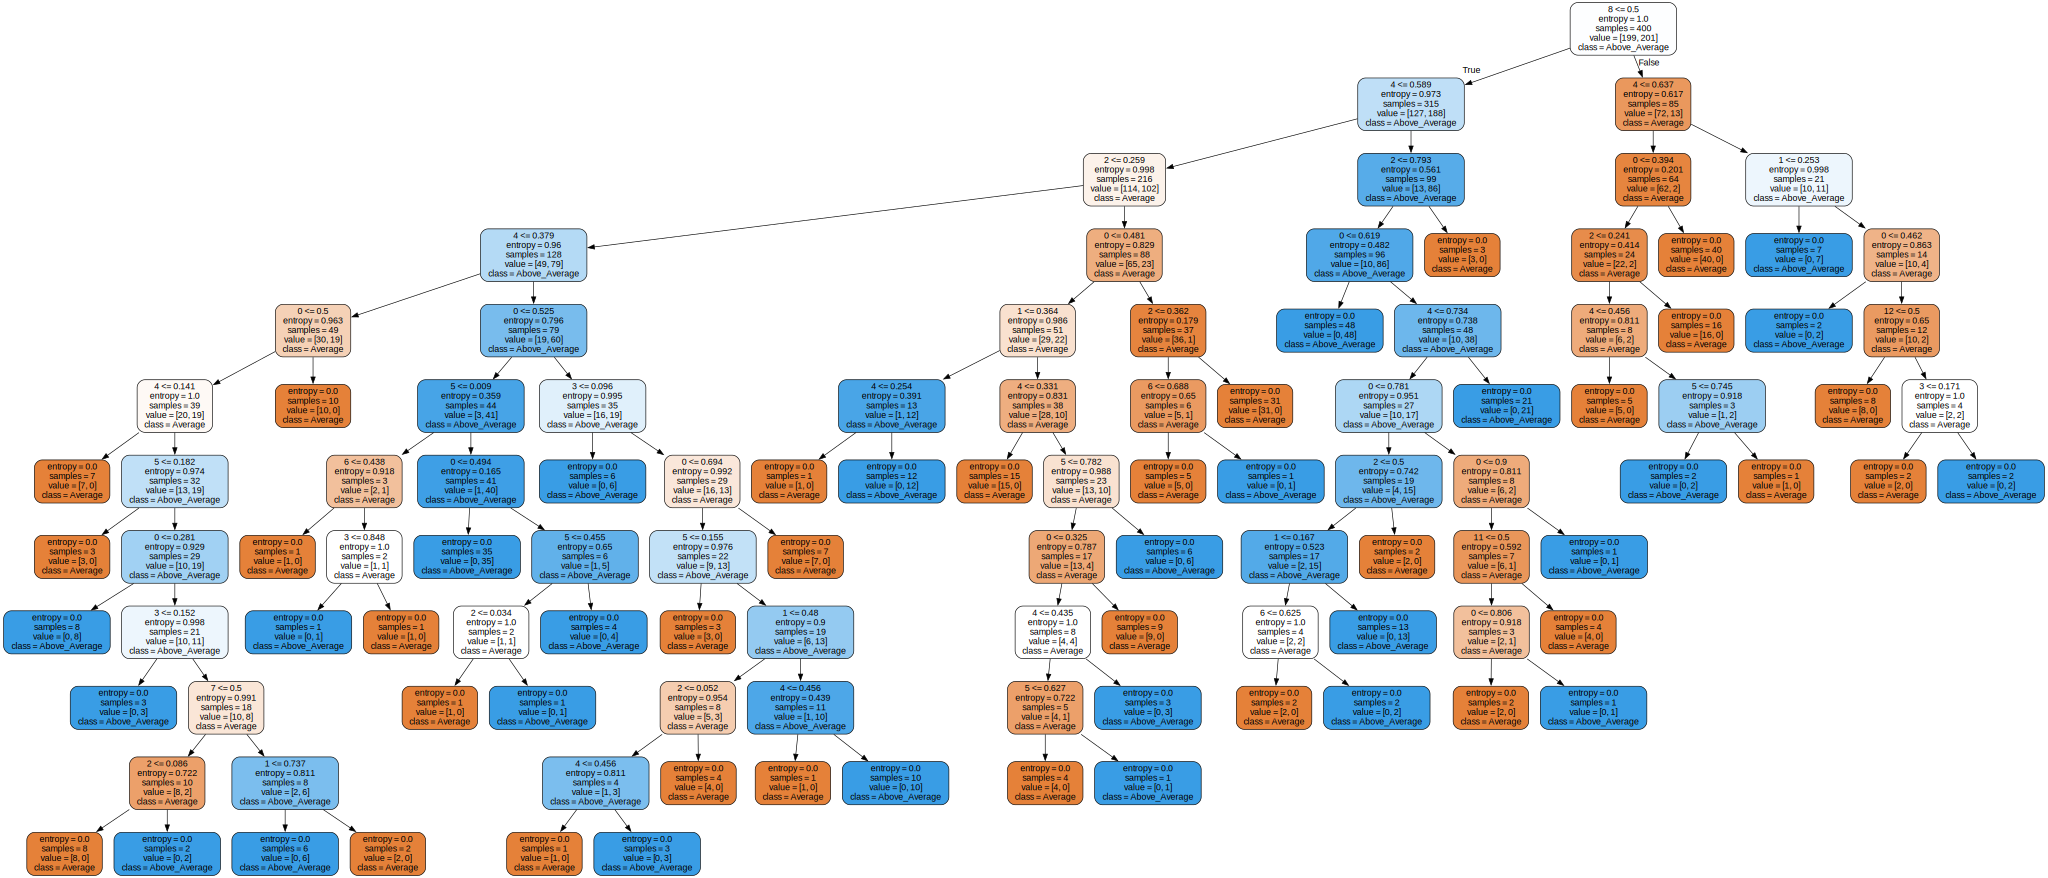

In [65]:
graph = graphviz.Source(dot_data)
graph

In [66]:
# Prediction on Train Data

preds_train = DT_best.predict(X_train)
preds_train

array(['Above_Average', 'Below_Average', 'Above_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Above_Average', '

In [67]:
# Confusion Matrix
pd.crosstab(Y_train, preds_train, rownames = ['Actual'], colnames = ['Predictions']) 

Predictions,Above_Average,Below_Average
Actual,,
Below_Average,0,161
Above_Average,159,0


In [68]:
# Accuracy

print(accuracy_score(Y_train, preds_train))

1.0


## Model Training with Cross Validation

In [69]:
from sklearn.model_selection import cross_validate


def cross_validation(model, _X, _y, _cv=5):
    
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
          This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    _cv: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                           X=_X,
                           y=_y,
                           cv=_cv,
                           scoring=_scoring,
                           return_train_score=True)

    return pd.DataFrame({"Training Accuracy scores": results['train_accuracy'],
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Training Precision scores": results['train_precision'],
          "Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          "Mean Training Recall": results['train_recall'].mean(),
          "Training F1 scores": results['train_f1'],
          "Mean Training F1 Score": results['train_f1'].mean(),
          "Validation Accuracy scores": results['test_accuracy'],
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          "Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          "Mean Validation Recall": results['test_recall'].mean(),
          "Validation F1 scores": results['test_f1'],
          "Mean Validation F1 Score": results['test_f1'].mean()
          })

In [70]:
from sklearn.preprocessing import LabelEncoder  # labelencoder is applied for target variable
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(Y_train)

label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))

print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")

Mapping of Label Encoded Classes
{'Above_Average': 0, 'Below_Average': 1}
Label Encoded Target Variable
[0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1
 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1
 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1
 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0]


In [71]:
encoded_y

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,

In [72]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_result = cross_validation(DT_best, X_train, encoded_y, 5)

In [73]:
decision_tree_result

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
0,1.000000,99.765625,1.000000,0.998462,1.000000,0.996899,1.000000,0.997671,0.734375,75.625,0.727273,0.747793,0.75000,0.776894,0.738462,0.761416
1,0.996094,99.765625,0.992308,0.998462,1.000000,0.996899,0.996139,0.997671,0.781250,75.625,0.764706,0.747793,0.81250,0.776894,0.787879,0.761416
2,0.996094,99.765625,1.000000,0.998462,0.992248,0.996899,0.996109,0.997671,0.812500,75.625,0.777778,0.747793,0.87500,0.776894,0.823529,0.761416
3,0.996094,99.765625,1.000000,0.998462,0.992248,0.996899,0.996109,0.997671,0.734375,75.625,0.727273,0.747793,0.75000,0.776894,0.738462,0.761416
4,1.000000,99.765625,1.000000,0.998462,1.000000,0.996899,1.000000,0.997671,0.718750,75.625,0.741935,0.747793,0.69697,0.776894,0.718750,0.761416


In [74]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

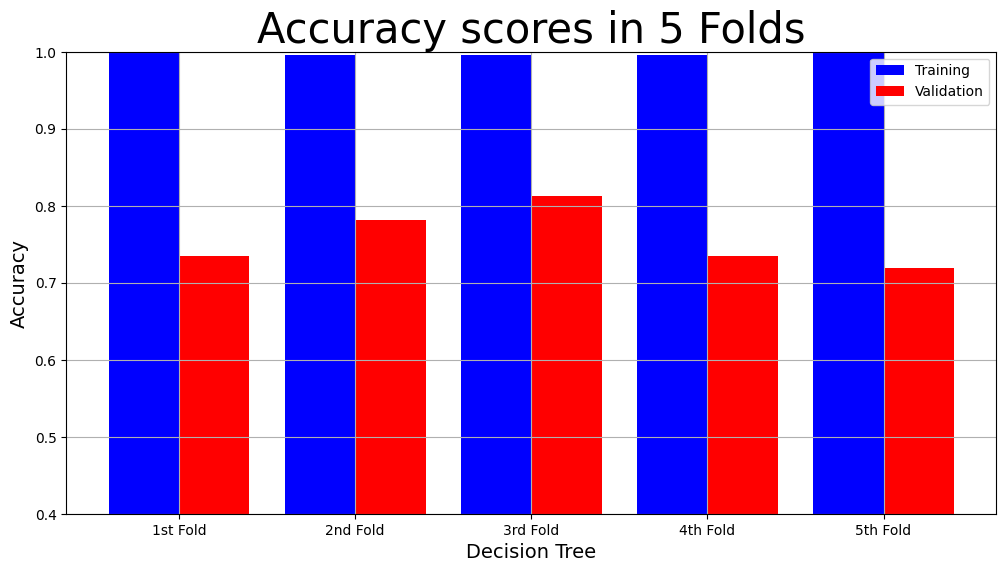

In [75]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result["Training Accuracy scores"],
            decision_tree_result["Validation Accuracy scores"])

## Random Forest Classifier

In [76]:
# creating random forest classifier
clf = RandomForestClassifier(n_estimators = 100)

In [77]:
# Training the model on the training dataset
clf.fit(X_train, Y_train)

RandomForestClassifier()

In [78]:
# predictions on the test dataset
y_pred = clf.predict(X_test)
y_pred

array(['Below_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Above_Average',
       'Above_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Below_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Above_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Below_Average', 'Below_Average', 'Below_Average',
       'Above_Average', 'Below_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Below_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Above_Average', 'Above_Average', 'Below_Average', 'Above_Average',
       'Below_Average', 'Above_Average', 'Above_Average', 'Below_Average',
       'Below_Average', '

In [79]:
print(accuracy_score(Y_test, y_pred))

0.75
